# 用Scikit-Learn实现常用分类器（Fashion MNIST）


## 一.引入相关库，初始化

In [4]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (15., 12.) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 二.数据加载
训练集/验证集/测试集划分：60000/5000/5000（验证集从测试集中按类别比例划分）

In [5]:
from sklearn.model_selection import train_test_split
import mnist_reader

#提取数据
X_train, y_train = mnist_reader.load_mnist('data', kind='train')
X_test, y_test = mnist_reader.load_mnist('data', kind='t10k')
print(X_train.shape)
print(X_test.shape)
print("")

#利用train_test_split将测试集按1:1划分为测试集和验证集
X_val,X_test,y_val,y_test = train_test_split(X_test,y_test,test_size=0.5,stratify=y_test)

#缩小数据集的规模6000:500:500
X_train,X,y_train,y = train_test_split(X_train,y_train,test_size=0.9,stratify=y_train)
X_val,X,y_val,y = train_test_split(X_val,y_val,test_size=0.9,stratify=y_val)
X_test,X,y_test,y = train_test_split(X_test,y_test,test_size=0.9,stratify=y_test)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)

(6000, 784)
(500, 784)
(500, 784)


## 三.构造分类器并进行训练
借助scikit-learn算法包快速实现

### 1.实现KNN分类器

In [6]:
from sklearn.neighbors import KNeighborsClassifier

#在验证集上验证K的取值对预测结果的影响
k_choices = [2,5,10,18,50]
for k in k_choices:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_val, y_val)
    print('k = %d, accuracy = %f' % (k, accuracy))

k = 2, accuracy = 0.784000
k = 5, accuracy = 0.800000
k = 10, accuracy = 0.798000
k = 18, accuracy = 0.790000
k = 50, accuracy = 0.780000


In [7]:
#在测试集上测试KNN模型的准确率
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print('k = 5, X_test accuracy = %f' % (accuracy))

k = 5, X_test accuracy = 0.802000


### 2.实现SVM分类器

In [8]:
from sklearn.svm import SVC

#在验证集上验证kernel的取值对预测结果的影响
kernel_choise = ['linear','poly','rbf','sigmoid']
for k in kernel_choise:
    clf = SVC(kernel=k)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_val, y_val)
    print('k = %s, accuracy = %f' % (k, accuracy))

k = linear, accuracy = 0.800000
k = poly, accuracy = 0.820000
k = rbf, accuracy = 0.206000
k = sigmoid, accuracy = 0.100000


In [9]:
#在测试集上测试SVM模型的准确率
clf = SVC(kernel='poly')
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print('k = poly, X_test accuracy = %f' % (accuracy))

k = poly, X_test accuracy = 0.834000


### 3.实现决策树分类器

best param: 8; best score: 0.796


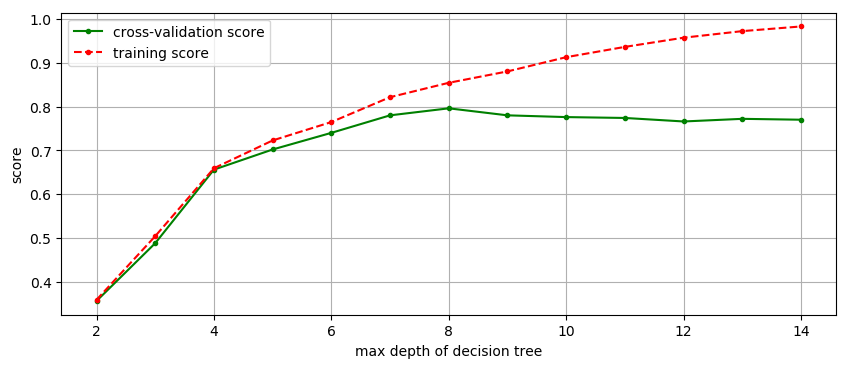

In [23]:
from sklearn.tree import DecisionTreeClassifier

#在验证集上验证max_depth的取值对预测结果的影响
def cv_score(d):
    clf = DecisionTreeClassifier(max_depth=d)
    clf.fit(X_train, y_train)
    tr_score = clf.score(X_train, y_train)
    cv_score = clf.score(X_val, y_val)
    return (tr_score, cv_score)

depths = range(2, 15)
scores = [cv_score(d) for d in depths]
tr_scores = [s[0] for s in scores]
cv_scores = [s[1] for s in scores]

best_score_index = np.argmax(cv_scores)
best_score = cv_scores[best_score_index]
best_param = depths[best_score_index]
print('best param: {0}; best score: {1}'.format(best_param, best_score))

plt.figure(figsize=(10, 4), dpi=100)
plt.grid()
plt.xlabel('max depth of decision tree')
plt.ylabel('score')
plt.plot(depths, cv_scores, '.g-', label='cross-validation score')
plt.plot(depths, tr_scores, '.r--', label='training score')
plt.legend()

In [28]:
#在测试集上测试决策树模型的准确率
clf = DecisionTreeClassifier(max_depth=8)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print ('X_test accuracy = %f' % (accuracy))

X_test accuracy = 0.760000
